In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy
import anndata


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

sc.set_figure_params(figsize=(4, 4))

palette = ['#fbbc04', '#199de5', '#cfe6d5']

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

# FEMALE

In [3]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path_to_gonads+'mouse-gonads_female.h5ad')

In [4]:
adata.obs['location'] = adata.obs['location'].tolist()
adata.obs.at[adata.obs['dataset'] == 'Niu2020', 'location'] = 'gonadal_and_extragonadal'

In [5]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_females_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['lineage'].to_dict()
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')


cell_annot = metaF['leiden'].to_dict()
adata.obs['leiden'] = adata.obs_names.map(cell_annot).astype('category')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (3,11,18,21,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_somatic_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['lineageSomatic'] = adata.obs_names.map(cell_annot)
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].fillna(adata.obs['lineage'])
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].astype('category')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (11,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
set(adata.obs['lineageSomatic'])

{'CoelEpi_Gata2',
 'CoelEpi_Gata2_cycling',
 'CoelEpi_Lhx9',
 'Doublet',
 'Endothelial',
 'Epithelial',
 'Epithelial_Wnt7a',
 'Erythroid',
 'FetalLeydig',
 'GermCells',
 'Gi',
 'Immune',
 'Mesenchymal_Crabp1',
 'Mesenchymal_Gata2',
 'Muscoskeletal',
 'Neural',
 'OSE',
 'Oi',
 'PV',
 'Sertoli',
 'Ti',
 'cont',
 'early_supporting',
 'granulosa',
 'lowQC',
 'preGC_I',
 'preGC_II',
 'sPAX8'}

# PLOTS

In [8]:
adata.obs['lineage'].cat.reorder_categories(['GermCells', 'CoelEpi_Gata2', 'CoelEpi_Lhx9', 'Supporting', 'preGranulosa', 'Mesenchymal_Lhx9',
                                              'Mesenchymal_Crabp1','Mesenchymal_Gata2', 'PV', 'Muscoskeletal',
                                              'Immune',  'Endothelial', 
                                              'Epithelial', 'Epithelial_Wnt7a',
                                                'Erythroid', 'Neural', 'lowQC', 'Doublet', 'cont'], inplace=True)

In [9]:
X = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
X = X[[i not in ['lowQC', 'Doublet', 'cont', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'preGranulosa', 'Sertoli', 'Ti', 'FetalLeydig'] for i in X.obs.lineageSomatic]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
colorsGen_df = pd.read_csv('gonads_general_colors_mouse.csv',index_col=0)
colorsGen_df

colorsSom_df = pd.read_csv('gonads_somatic_colors_mouse.csv',index_col=0)
colorsSom_df

colors_df = colorsGen_df.append(colorsSom_df, ignore_index=False).drop_duplicates()

idx = [colors_df.index.tolist().index(i) for i in adata.obs['lineage'].cat.categories.tolist() ]
X.uns['lineage_colors'] = [ colors_df.color[i] for i in idx ]

idx = [colors_df.index.tolist().index(i) for i in X.obs['lineageSomatic'].cat.categories.tolist() ]
X.uns['lineageSomatic_colors'] = [ colors_df.color[i] for i in idx ]

label_annot = colors_df['label'].to_dict()
X.obs['labels'] = X.obs['lineageSomatic'].map(label_annot)

colors_df = colors_df.set_index('label')
label2color_annot = colors_df['color'].to_dict()
from natsort import natsorted
x = natsorted(list(set(X.obs['labels'])))
X.uns['labels_colors'] = [ label2color_annot[i] for i in  x ]

Trying to set attribute `.uns` of view, copying.


In [11]:
print('Total number of cells: {:d}'.format(X.n_obs))
print('Total number of cells: {:d}'.format(X[[ i in 'Sanger' for i in X.obs.dataset ]].n_obs))
print('Total number of genes: {:d}'.format(X.n_vars))

Total number of cells: 69580
Total number of cells: 31337
Total number of genes: 25834


... storing 'location' as categorical
... storing 'labels' as categorical
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


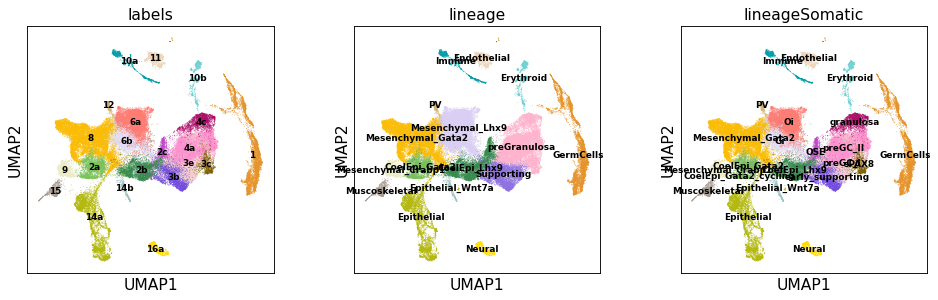

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


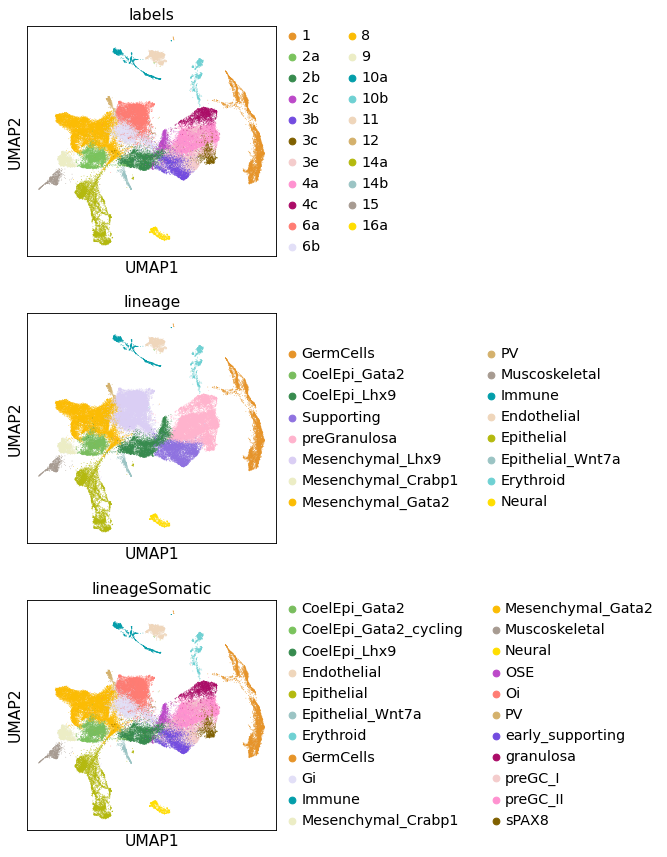

In [12]:
# plt.rcParams['figure.figsize'] = (4,4)
sc.pl.umap(X, color=['labels', 'lineage', 'lineageSomatic'], legend_loc='on data', legend_fontsize=8, save='_mouse_female_labelsON.pdf')


with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(X, color=['labels', 'lineage', 'lineageSomatic'], ncols=1, save='_mouse_female_legend.pdf')

In [13]:
import re
X.obs['stage_merged'] = [ re.sub('^1', 'E1', i) for i in X.obs.stage ]
pal_stage_merged = ['#E85C90', '#C481A7','#A0A6BE','#7CCAD5','#58EFEC','#6ce6bf', '#d8eb9b', '#ebcb9b']

... storing 'stage_merged' as categorical


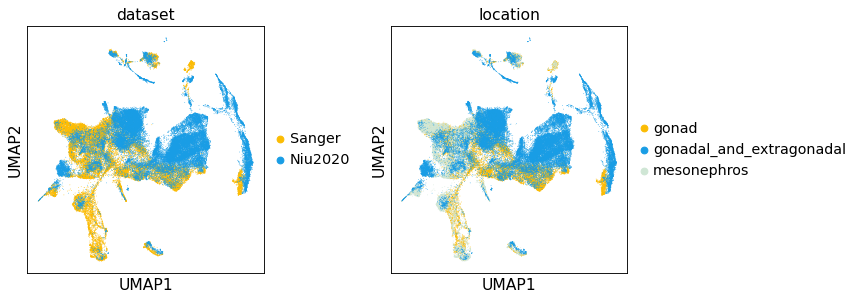

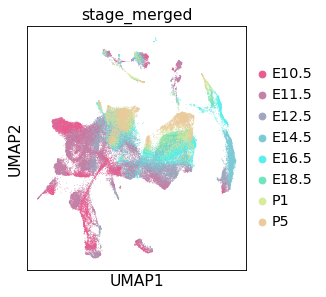

In [14]:
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
    X,
    color=['dataset', 'location'], palette=palette,
    frameon=True, ncols = 2, wspace = 0.4, save='_mouse_female_metadata_I.pdf'
)
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
        X,
        color=["stage_merged"], palette=pal_stage_merged,
        frameon=True, ncols = 2, wspace = 0.3, save='_mouse_female_metadata_II.pdf'
    )

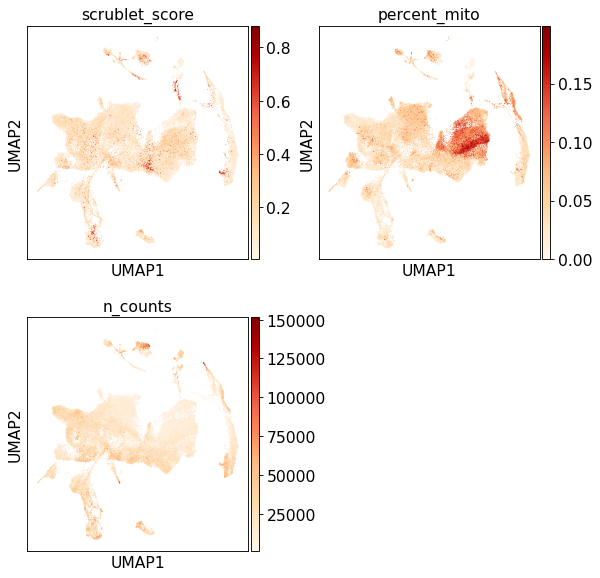

In [15]:
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
    X,
    color=['scrublet_score',  'percent_mito', 'n_counts'], color_map = "OrRd",
    frameon=True, ncols = 2, wspace = 0.2, save='_mouse_female_metadata_III.pdf'
)


... storing 'location' as categorical


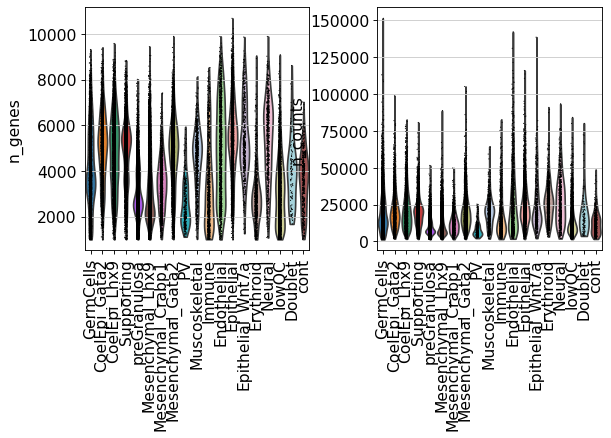

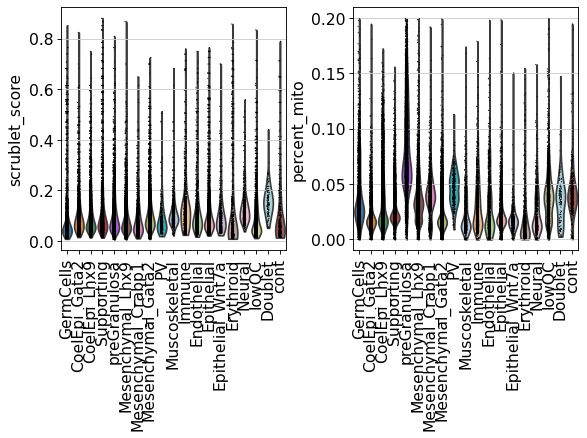

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='lineage', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='lineage', rotation=90)

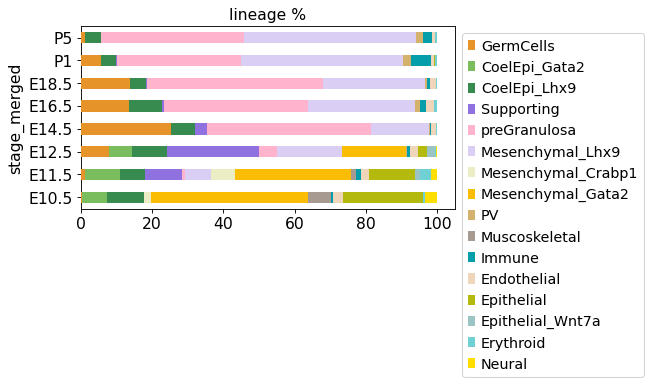

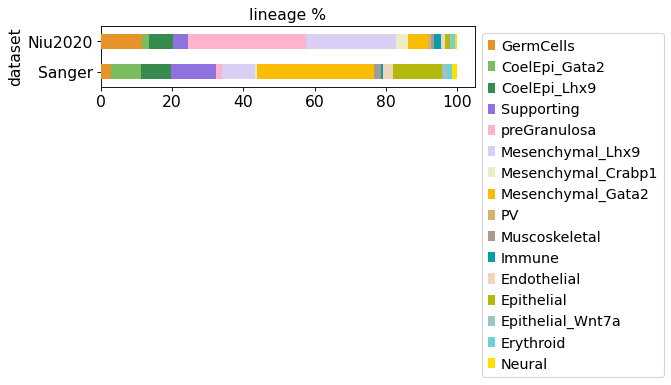

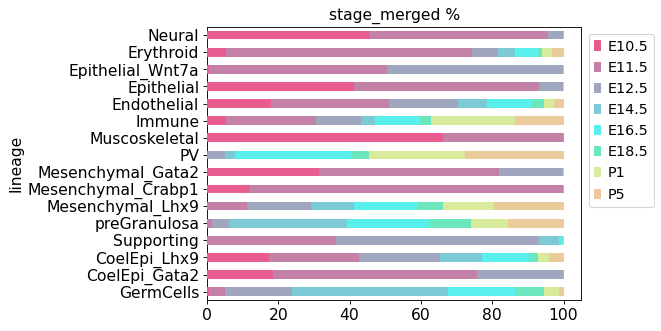

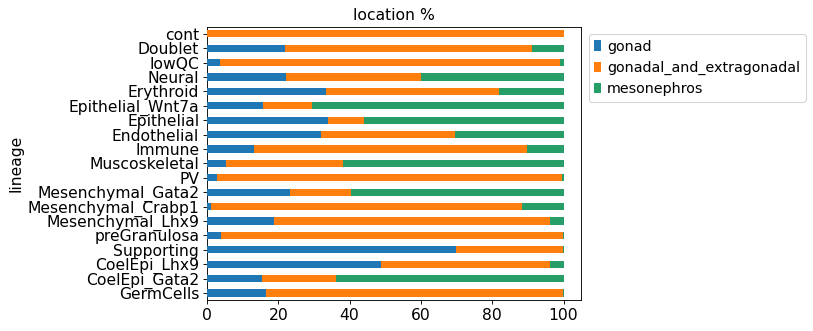

In [17]:
Barplot('lineage', X, var='stage_merged', height=3, color = X.uns['lineage_colors'])
Barplot('lineage', X, var='dataset', height=1, color = X.uns['lineage_colors'])
Barplot('stage_merged', X, var='lineage', height=4.5, color = pal_stage_merged)
Barplot('location', adata, var='lineage', height=4.5)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


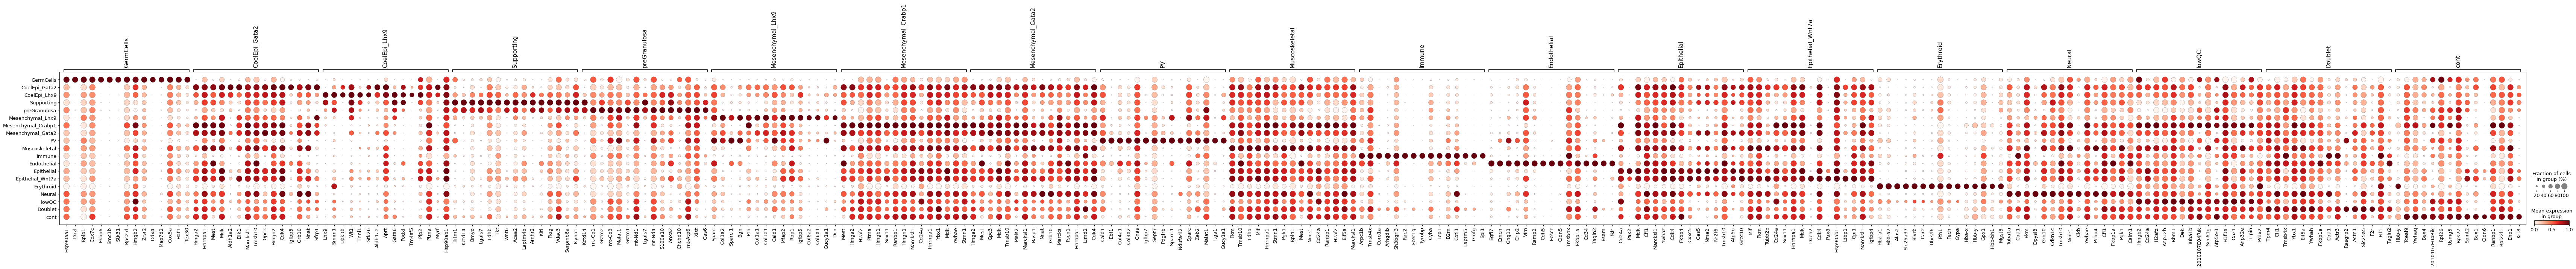

In [18]:
sc.tl.rank_genes_groups(adata, groupby='lineage', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')

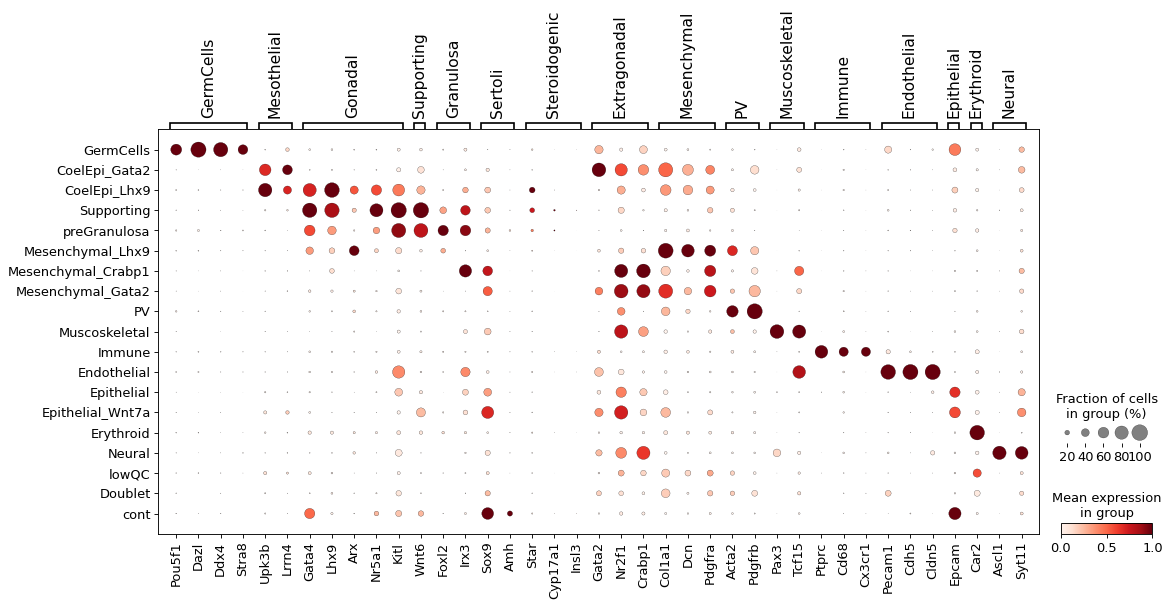

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


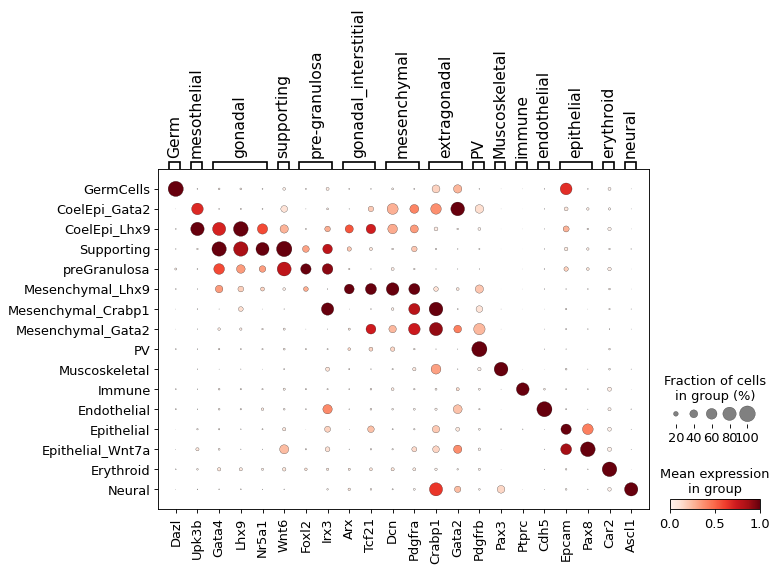

In [19]:
marker_genes = {'GermCells' : ['Pou5f1', 'Dazl', 'Ddx4', 'Stra8'], 
'Mesothelial' : ['Upk3b', 'Lrrn4'], 
'Gonadal' : ["Gata4", "Lhx9", 'Arx', 'Nr5a1',  'Kitl'], 
'Supporting' : ['Wnt6'], 
#  'early_supporting' : ['Lgr5', 'Tspan8', 'Cxcr4', 'Plac1', "Gfra3",'Gpr37'],
#  'sPAX8' : ['Pax8', 'Lypd1', 'Tbx1', 'Tbx2', 'Aldh1a3', 'Pdgfrl'], 
'Granulosa' : [ 'Foxl2', 'Irx3'], 
 'Sertoli':['Sox9', 'Amh'],
 'Steroidogenic' : ['Star', 'Cyp17a1', 'Insl3'], 
 'Extragonadal' : ['Gata2',  'Nr2f1', 'Crabp1'], 
 'Mesenchymal' : ['Col1a1', 'Dcn', 'Pdgfra'],
 'PV':['Acta2', 'Pdgfrb'], 
 'Muscoskeletal':['Pax3', 'Tcf15'],
 'Immune' : ['Ptprc', 'Cd68', 'Cx3cr1'], 
 'Endothelial' : ['Pecam1', 'Cdh5', 'Cldn5'],
 'Epithelial' : ['Epcam'], 
 'Erythroid' : ['Car2'], 
 'Neural' : ['Ascl1', 'Syt11']
}
sc.pl.dotplot(adata, marker_genes, groupby='lineage', use_raw=False, standard_scale = 'var')

marker_genes_short = {
    'Germ': {'Dazl'}, 
    'mesothelial': {'Upk3b'},
    'gonadal':{"Gata4", "Lhx9", 'Nr5a1'},
    'supporting':{'Wnt6'}, # WNT6, WIPF3, MIR202HG are new
    'pre-granulosa':{'Foxl2', 'Irx3'},
#     'Sertoli': {'Sox9', 'Amh'},
    'gonadal_interstitial':{ 'Arx',  'Tcf21'},
    'mesenchymal':{'Dcn', 'Pdgfra'},
    'extragonadal':{'Gata2', 'Crabp1'},
    'PV': {'Pdgfrb'},
     'Muscoskeletal':['Pax3'],
    'immune': {'Ptprc'},
    'endothelial': {'Cdh5'},
    'epithelial': {"Epcam", 'Pax8'},
    'erythroid': {"Car2"},
    'neural': {'Ascl1'}
}
sc.pl.dotplot(adata[[i not in ['cont', 'Doublet', 'lowQC'] for i in adata.obs.lineage]], 
              marker_genes_short, groupby='lineage', use_raw=False, standard_scale = 'var', save='female_markers.pdf')

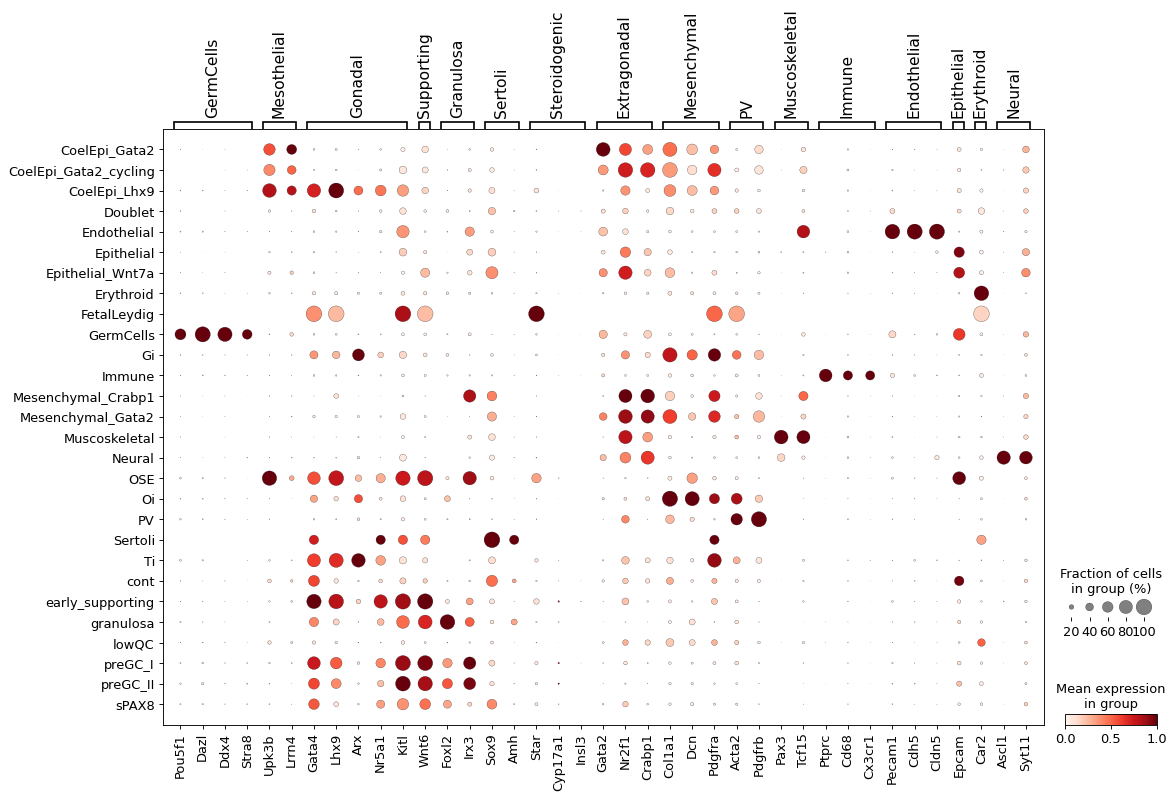

In [20]:
sc.pl.dotplot(adata, marker_genes, groupby='lineageSomatic', use_raw=False, standard_scale = 'var')

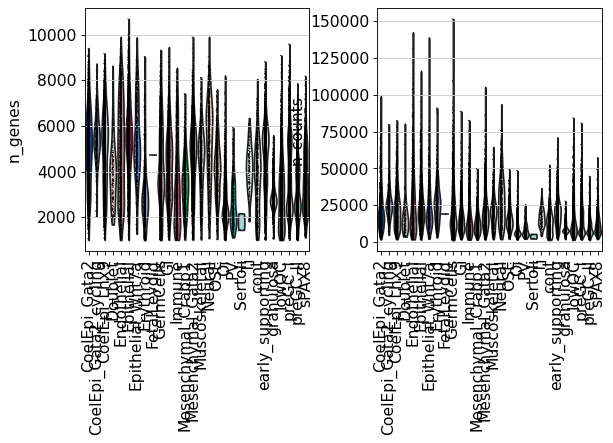

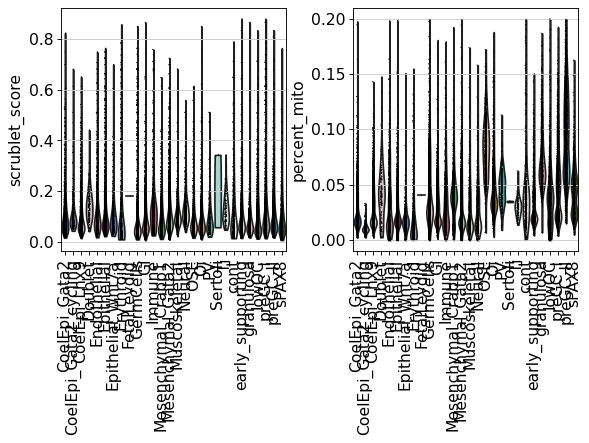

In [21]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='lineageSomatic', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='lineageSomatic', rotation=90)

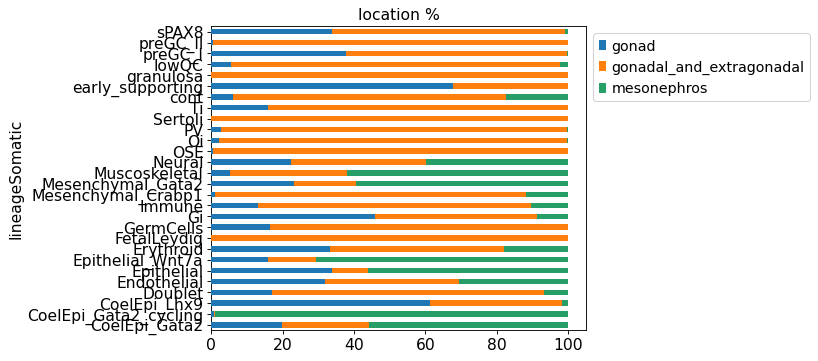

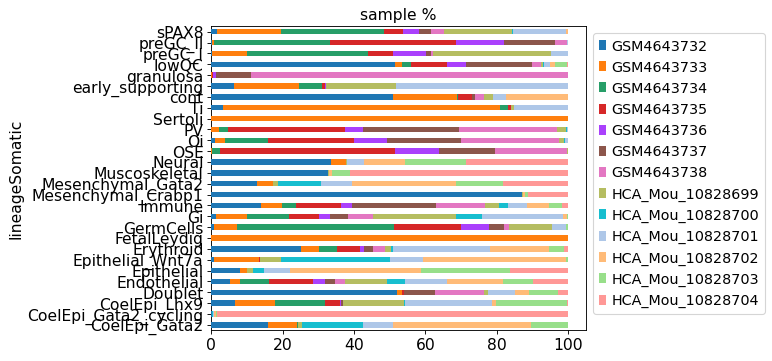

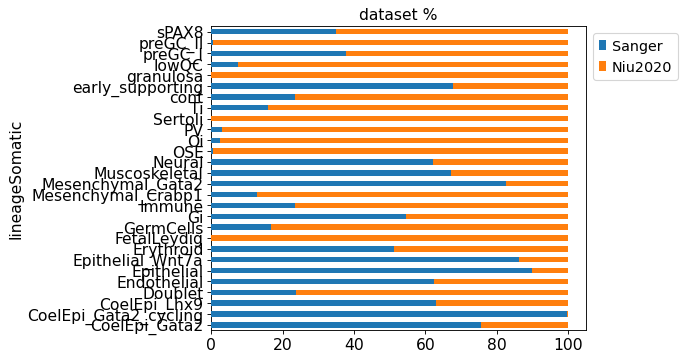

In [22]:
Barplot('location', adata, var='lineageSomatic', height=5)
Barplot('sample', adata, var='lineageSomatic', height=5)
Barplot('dataset', adata, var='lineageSomatic', height=5)